In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime, FastMarkerCluster
import ipywidgets as widgets
import geopandas as gpd
import fiona
import json
import plotly.express as px
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
from IPython.display import HTML, display
from collections import defaultdict
from shapely.geometry import Point
pd.set_option('display.max_rows', 999)

https://ocefpaf.github.io/python4oceanographers/blog/2014/05/05/folium/<br>
https://github.com/jasonamyers/nss-geospatial-project-1/blob/master/notebooks/Permits%20by%20District.ipynb<br>
https://eric.clst.org/tech/usgeojson/<br>
### Tennessee counties by region is a standalone data file

In [2]:
tenn_eq = pd.read_csv('../Data/tenn_eq.csv')

In [3]:
tn_county_region = pd.read_csv('../Data/tn_county_region.csv')
tn_county_region.head()

,county_name,tdot_region,tdot_code
0,Anderson,1,1
1,Bedford,3,2
2,Benton,4,3
3,Bledsoe,2,4
4,Blount,1,5


In [4]:
tn_county_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county_name  95 non-null     object
 1   tdot_region  95 non-null     int64 
 2   tdot_code    95 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [5]:
#Correct a misspelling
#tn_county_region[tn_county_region['county_name']=='Dekalb']['county_name']
tn_county_region.loc[tn_county_region['county_name']=='Dekalb', 'county_name'] = 'DeKalb'

In [6]:
#Get the boundaries of all US counties
us_county_path = '../Data/gz_2010_us_050_00_500k.json'
cur_json = json.load(open(us_county_path, encoding='ISO-8859-1'))
#path,ext = os.path.splitext(us_county_path)
path,ext = us_county_path.rsplit('.', 1)
new_path =path+"_new"+ext
with open(new_path,"w", encoding='utf-8') as jsonfile:
        json.dump(cur_json,jsonfile,ensure_ascii=False)
us_county = gpd.read_file(new_path, driver='GeoJSON')
#What are our columns?
us_county.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry'], dtype='object')

In [7]:
#What does this dataset look like?
us_county.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_ID      3221 non-null   object  
 1   STATE       3221 non-null   object  
 2   COUNTY      3221 non-null   object  
 3   NAME        3221 non-null   object  
 4   LSAD        3221 non-null   object  
 5   CENSUSAREA  3221 non-null   float64 
 6   geometry    3221 non-null   geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 176.3+ KB


In [8]:
#Look at some data
us_county.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38089 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00409 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [9]:
#Which state is Tennessee?
us_county[us_county['NAME'] == 'Obion']

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
2512,0500000US47131,47,131,Obion,County,544.728,"POLYGON ((-88.85526 36.50267, -88.83463 36.502..."


In [10]:
#We only want Tenn
tenn_county = us_county[us_county['STATE'] == '47']

In [11]:
#Merge in our tdot region data
tenn_county_region = tenn_county.merge(tn_county_region, left_on='NAME', right_on='county_name', how='inner')
#Make sure we still have all 95 counties
tenn_county_region.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   GEO_ID       95 non-null     object  
 1   STATE        95 non-null     object  
 2   COUNTY       95 non-null     object  
 3   NAME         95 non-null     object  
 4   LSAD         95 non-null     object  
 5   CENSUSAREA   95 non-null     float64 
 6   geometry     95 non-null     geometry
 7   county_name  95 non-null     object  
 8   tdot_region  95 non-null     int64   
 9   tdot_code    95 non-null     int64   
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 8.2+ KB


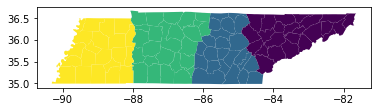

In [12]:
#Hey look, pretty colors
tenn_county_region.plot('tdot_region');

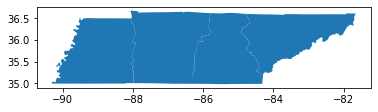

In [13]:
#Hey look, useful polygons, thanks Jason!
tenn_county_region.dissolve('tdot_region').plot();

In [14]:
#Pull out our polygons to use in a map overlay
tenn_region_poly = tenn_county_region.dissolve('tdot_region')['geometry']

In [15]:
#tenn_region_poly
#type(tenn_region_poly)

In [16]:
#Check out our eq data
tenn_eq.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-10-25T17:18:57.880Z,35.666833,-84.024667,18.54,2.45,md,23.0,80.0,0.1405,0.18,...,2020-10-27T15:36:56.862Z,Tennessee,earthquake,0.31,0.59,0.089,17.0,reviewed,se,se
1,2020-10-19T20:19:38.490Z,36.224000,-82.817167,17.27,2.31,md,8.0,70.0,0.1751,0.12,...,2020-10-23T06:52:55.336Z,"6 km N of Greeneville, Tennessee",earthquake,0.91,1.69,0.099,6.0,reviewed,se,se
2,2020-10-17T07:12:44.060Z,35.366833,-85.213500,17.99,2.26,md,16.0,59.0,0.1587,0.14,...,2020-10-17T13:54:48.250Z,"4 km NNW of Flat Top Mountain, Tennessee",earthquake,0.33,0.60,0.152,15.0,reviewed,se,se
3,2020-10-09T20:24:02.590Z,36.101833,-83.637833,16.48,2.30,md,14.0,83.0,0.2041,0.11,...,2020-10-15T02:32:20.631Z,"7 km W of New Market, Tennessee",earthquake,0.29,0.94,0.090,10.0,reviewed,se,se
4,2020-09-13T11:45:06.680Z,35.706333,-83.916833,18.34,2.47,md,22.0,40.0,0.1259,0.16,...,2020-09-26T09:49:46.040Z,"7 km SE of Maryville, Tennessee",earthquake,0.24,0.52,0.080,18.0,reviewed,se,se


In [17]:
#Function for geometry
def lat_long_to_point(row):
    return Point(row['longitude'], row['latitude'])

In [18]:
#Column for geometry
tenn_eq['position'] = tenn_eq.apply(lat_long_to_point, axis=1)

In [19]:
#Make our geodf
tenn_eq_geo = gpd.GeoDataFrame(tenn_eq, crs='epsg:4326', geometry=tenn_eq['position'])
#And check out the columns
tenn_eq_geo.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'position', 'geometry'],
      dtype='object')

In [20]:
#merge in the region data with the eq data
tenn_eq_geo_map = gpd.sjoin(tenn_eq_geo, tenn_county_region, op='within')
#And check out the columns
tenn_eq_geo_map.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'position', 'geometry', 'index_right',
       'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA',
       'county_name', 'tdot_region', 'tdot_code'],
      dtype='object')

In [21]:
#Base map
tenn_map = folium.Map(tiles='Stamen Terrain', location=[36.224,-82.8171667], zoom_start=6)

In [22]:
##### Well, this didn't work quite right, so we'll leave it for later. :-)
def color_region(x):
    if x['id'] == '1':
        return {'fillColor': '#7b3294'}
    if x['id'] == '2':
        return {'fillColor': '#c2a5cf'}
    if x['id'] == '3':
        return {'fillColor': '#a6dba0'}
    if x['id'] == '4':
        return {'fillColor': '#008837'}
    print(x)

In [23]:
#Add in our region polygons, because they are so very cool
folium.GeoJson(tenn_region_poly, lambda x: color_region(x) , overlay=False).add_to(tenn_map)
#{'fillColor': '#A020F0'}
#style_function=color_region

In [24]:
#Make a heatmap layer with the eq data
heatmapdata = [
    (row['geometry'].y, row['geometry'].x, row['mag']) for idx, row
        in tenn_eq_geo_map.iterrows()
            if row['geometry'] and not pd.isna(row['geometry'].x) and not pd.isna(row['geometry'].y and not pd.isna(row['mag']))
        ]

In [25]:
#heatmapdata

In [26]:
hm = HeatMap(data=heatmapdata)
hm.add_to(tenn_map);
tenn_map

In [27]:
tenn_map.save('tn_region_heatmap.html')

In [28]:
tenn_eq.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,position,geometry
0,2020-10-25T17:18:57.880Z,35.666833,-84.024667,18.54,2.45,md,23.0,80.0,0.1405,0.18,...,earthquake,0.31,0.59,0.089,17.0,reviewed,se,se,POINT (-84.0246667 35.6668333),POINT (-84.02467 35.66683)
1,2020-10-19T20:19:38.490Z,36.224000,-82.817167,17.27,2.31,md,8.0,70.0,0.1751,0.12,...,earthquake,0.91,1.69,0.099,6.0,reviewed,se,se,POINT (-82.8171667 36.224),POINT (-82.81717 36.22400)
2,2020-10-17T07:12:44.060Z,35.366833,-85.213500,17.99,2.26,md,16.0,59.0,0.1587,0.14,...,earthquake,0.33,0.60,0.152,15.0,reviewed,se,se,POINT (-85.2135 35.3668333),POINT (-85.21350 35.36683)
3,2020-10-09T20:24:02.590Z,36.101833,-83.637833,16.48,2.30,md,14.0,83.0,0.2041,0.11,...,earthquake,0.29,0.94,0.090,10.0,reviewed,se,se,POINT (-83.6378333 36.1018333),POINT (-83.63783 36.10183)
4,2020-09-13T11:45:06.680Z,35.706333,-83.916833,18.34,2.47,md,22.0,40.0,0.1259,0.16,...,earthquake,0.24,0.52,0.080,18.0,reviewed,se,se,POINT (-83.91683329999999 35.7063333),POINT (-83.91683 35.70633)


In [29]:
tenn_eq['time'] = pd.to_datetime(tenn_eq['time'])

In [30]:
data_points = []
for idx, row in tenn_eq.sort_values('time').iterrows():
    if row['geometry'] and not pd.isna(row['geometry'].x) and not pd.isna(row['geometry'].y):
        data_points.append((row['time'].to_pydatetime(), row['geometry'].y, row['geometry'].x))
        

by_year=defaultdict(list)
for record in data_points:
    by_year[f'{record[0].strftime("%Y")}'].append([record[1],record[2], 1])
    
over_time = []
time_index = []
for key, values in by_year.items():
    over_time.append(values)
    time_index.append(key)

In [31]:
tenn_map_heat = folium.Map(tiles='OpenStreetMap', location=[36.224,-82.8171667], zoom_start=6)
folium.GeoJson(tenn_region_poly, lambda x: color_region(x) , overlay=False).add_to(tenn_map_heat)
hm = HeatMapWithTime(data=over_time,
    index=time_index,
    auto_play=False,
    max_opacity=0.3,
    min_speed=4
    )
hm.add_to(tenn_map_heat)

In [32]:
tenn_map_heat

In [33]:
tenn_map_heat.save('tn_timeline.html')

In [34]:
#Eq's of 2.5 magnitude and over can be detected (i.e., felt by people) without instruments.
tenn_eq['mag'].describe()

count    1076.000000
mean        1.902063
std         0.620258
min         0.000000
25%         1.500000
50%         1.900000
75%         2.282500
max         4.600000
Name: mag, dtype: float64

In [35]:
#Make a df of eq's above 2.5 magnitude
tenn_eq_top_map = tenn_eq_geo_map[tenn_eq_geo_map['mag']> 2.5]

In [36]:
tenn_eq_top_map.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,index_right,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,county_name,tdot_region,tdot_code
155,2019-01-14T09:00:26.930Z,35.770833,-83.955667,13.01,2.73,md,28.0,33.0,0.16210,0.17,...,8,0500000US47009,47,009,Blount,County,558.706,Blount,1,5
278,2017-07-23T13:22:58.710Z,35.725000,-84.165000,22.57,2.73,md,19.0,62.0,0.05717,0.16,...,8,0500000US47009,47,009,Blount,County,558.706,Blount,1,5
329,2016-10-25T02:42:50.480Z,35.815833,-84.093833,3.32,2.70,md,31.0,36.0,0.15570,0.25,...,8,0500000US47009,47,009,Blount,County,558.706,Blount,1,5
719,2010-04-22T02:14:55.610Z,35.735167,-84.002000,1.67,2.60,mlg,23.0,40.0,NaN,0.20,...,8,0500000US47009,47,009,Blount,County,558.706,Blount,1,5
721,2010-04-20T09:28:20.040Z,35.725167,-84.001000,2.24,3.30,mlg,28.0,41.0,NaN,0.16,...,8,0500000US47009,47,009,Blount,County,558.706,Blount,1,5


In [37]:
tenn_eq_top_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 111 entries, 155 to 1070
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   time             111 non-null    object  
 1   latitude         111 non-null    float64 
 2   longitude        111 non-null    float64 
 3   depth            108 non-null    float64 
 4   mag              111 non-null    float64 
 5   magType          111 non-null    object  
 6   nst              96 non-null     float64 
 7   gap              96 non-null     float64 
 8   dmin             78 non-null     float64 
 9   rms              96 non-null     float64 
 10  net              111 non-null    object  
 11  id               111 non-null    object  
 12  updated          111 non-null    object  
 13  place            111 non-null    object  
 14  type             111 non-null    object  
 15  horizontalError  96 non-null     float64 
 16  depthError       96 non-null     

In [38]:
tenn_map_top = folium.Map(tiles='Stamen Terrain', location=[36.224,-82.8171667], zoom_start=6)

In [39]:
folium.GeoJson(tenn_region_poly, lambda x: color_region(x), overlay=False).add_to(tenn_map_top);

In [40]:
heatmapdata_top = [
    (row['geometry'].y, row['geometry'].x, row['mag']) for idx, row
        in tenn_eq_top_map.iterrows()
            if row['geometry'] and not pd.isna(row['geometry'].x) and not pd.isna(row['geometry'].y and not pd.isna(row['mag']))
        ]

In [41]:
hm_top = HeatMap(data=heatmapdata_top)

In [42]:
hm_top.add_to(tenn_map_top);

In [43]:
tenn_map_top

In [44]:
#Returning to the full data set
tenn_eq_geo_map.groupby(['tdot_region']).count()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,geometry,index_right,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,county_name,tdot_code
tdot_region,,,,,,,,,,,,,,,,,,,,,
1,707,707,707,706,707,707,690,690,655,690,...,707,707,707,707,707,707,707,707,707,707
2,309,309,309,309,309,309,305,305,289,305,...,309,309,309,309,309,309,309,309,309,309
3,21,21,21,21,21,21,15,15,13,15,...,21,21,21,21,21,21,21,21,21,21
4,16,16,16,14,16,16,6,6,3,6,...,16,16,16,16,16,16,16,16,16,16


In [45]:
eq_count_by_region = tenn_eq_geo_map.groupby(['tdot_region'])['mag'].count()                           

In [46]:
region_names = pd.Series({'1':'Knoxville','2':'Chattanooga','3':'Nashville','4':'Memphis'})

In [47]:
count_by_region_name = pd.concat([eq_count_by_region.reset_index(drop=True),region_names.reset_index(drop=True)], axis=1)

In [48]:
count_by_region_name.columns = ['Count', 'Region']

In [68]:
eq_region = px.bar(count_by_region_name, x='Region', y='Count', title='Earthquake count by TDOT Region', color='Count', 
                   text='Count', colorscale='Viridis')

TypeError: bar() got an unexpected keyword argument 'colorscale'

In [69]:
# !conda install psutil -y

In [58]:
# !conda install -c plotly plotly-orca -y

In [65]:
eq_region.update_traces(texttemplate='%{text:.2s}', textposition='outside')

In [66]:
eq_region

In [67]:
eq_region.write_image('eq_by_region.png')

# Earthquakes in dataset = 1075
## Region 1 (Knoxville) = 706
## Region 2 (Chattanooga) = 309
## Region 3 (Nashville) = 21
## Region 4 (Memphis) = 16

In [ ]:
#Counts by region for eq's over 2.5 magnitude
tenn_eq_top_map.groupby(['tdot_region']).count()

# Magnitude 2.5+ in dataset = 111
## Region 1 (Knoxville) = 72
## Region 2 (Chattanooga) = 30
## Region 3 (Nashville) = 1
## Region 4 (Memphis) = 8